# Super-Resolution


In [ ]:
#@title Required imports

!pip install -qU gdown --progress-bar off
!pip install -qU tensorflow-addons --progress-bar off

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *

import os
import time
from datetime import datetime
import json
import shutil
from typing import *
import threading

import gdown
from zipfile import ZipFile
from tqdm.notebook import tqdm_notebook

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done



In [ ]:
#@title Utils functions

def load_model_from_wandb(run_path, model_type, debug=False):
  generator_path = wandb.restore("generator-{}.h5".format(model_type), run_path=run_path, replace=True)
  discriminator_path = wandb.restore("discriminator-{}.h5".format(model_type), run_path=run_path, replace=True)

  saved_generator = tf.keras.models.load_model(generator_path.name, custom_objects={"MySubpixelConv2D": MySubpixelConv2D})
  saved_discriminator = tf.keras.models.load_model(discriminator_path.name, custom_objects={"MySubpixelConv2D": MySubpixelConv2D})

  api = wandb.Api()
  run = api.run(run_path)

  if run.config["use_canny"]:
    loaded_model = SuperResolutionCannyGAN(
      generator=saved_generator,
      discriminator=saved_discriminator,
      hr_shape=(96, 96, 3),
      adversarial_loss_weight=run.config["adversarial_loss_weight"],
      content_loss_weight=run.config["content_loss_weight"],
      canny_loss_weight=run.config["canny_loss_weight"],
      lr=run.config["learning_rate"],
      gen_blocks=run.config["gen_blocks"], 
      use_vgg=run.config["use_vgg"],
      train_generator_only=run.config["train_generator_only"]
    )
  else:
    loaded_model = SuperResolutionGAN(
        generator=saved_generator,
        discriminator=saved_discriminator,
        hr_shape=(96, 96, 3),
        adversarial_loss_weight=run.config["adversarial_loss_weight"],
        content_loss_weight=run.config["content_loss_weight"],
        lr=run.config["learning_rate"],
        gen_blocks=run.config["gen_blocks"], 
        use_vgg=run.config["use_vgg"],
        train_generator_only=run.config["train_generator_only"]
    )
  
  loaded_model.compile()

  return loaded_model

def load_image_dataset(paths, channels = 3):
  ds = tf.data.Dataset.from_tensor_slices(paths)

  ds = ds.map(tf.io.read_file, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(lambda x : tf.io.decode_png(x, channels = channels), num_parallel_calls=tf.data.AUTOTUNE)
  
  return ds

def get_progress_bar(value: int, total: int, len=20):
  progress = value * len // total
  remaining = len - progress
  progress_str = "=" * progress
  remaining_str = " " * remaining
  return "[" + progress_str + remaining_str + "]"

def download_dataset(name: str, gdrive_id: str, unzip=True, quiet=True):
  if os.path.isfile(name):
    print("{} already downloaded.".format(name))
    return

  url = "https://drive.google.com/uc?id={}&confirm=t".format(gdrive_id)
  output = "/content/" + name
  gdown.download(url, output, quiet=quiet)

  if unzip:
    with ZipFile("/content/" + name, "r") as f:
      f.extractall("/content/")

def download_datasets(names_dict: Dict[str, str], unzip=True):
  for name, gdrive_id in names_dict.items():
    print("Downloading", name)
    download_dataset(name, gdrive_id, unzip)

def cast_img_to_uint8(image):
  if type(image) != np.ndarray:
    return image.numpy().astype(np.uint8)
  return image.astype(np.uint8)

def plot_img(image, cmap = None):
  plt.imshow(cast_img_to_uint8(image), cmap = cmap)

def save_img(name, image, cmap = None):
  plt.imsave(name, cast_img_to_uint8(image), cmap = cmap)

def plot_img_0_1(image, cmap=None):
  plot_img(image * 255, cmap = cmap)

def save_img_0_1(name, image, cmap = None):
  save_img(name, image * 255, cmap)

def plot_img_1_1(image, cmap=None):
  plot_img(image * 127.5 + 127.5, cmap = cmap)

def save_img_1_1(name, image, cmap = None):
  save_img(name, image * 127.5 + 127.5, cmap)

## Load datasets

In this section we load all the datasets used in the project.


In [ ]:
#@title Download datasets

only_test_sets = False #@param {type:"boolean"}

train_sets = {
  "DIV2K_train_HR.zip": "1rvaR9PcJGR1x9IuHxjseaC4CJ0UEn901",
  "DIV2K_train_LR_difficult.zip": "1pa9VNrd_TaKyFm3LwOPg3mMzjyYO7Mkw",
  "DIV2K_train_LR_mild.zip": "1Hi9oLRvIjR_kuvDog4OwI_fX0T63fx9M",
  "DIV2K_train_LR_wild.zip": "1NnOiSpzO5Ci8xZcN-mrVJOrt8gqiqdVR",
  "DIV2K_train_LR_x4.zip": "1csVAZeM-fYAjcxugP-7kCMECr8h254ss",
  "DIV2K_train_LR_x8.zip": "1G6REj54S_x0h_g0CE1c9pbrOgEYt-boA",
  "DIV2K_valid_HR.zip": "1ueg-uwVnm3V-EIk8ZNeUCqStMXX3loOs",
  "DIV2K_valid_LR_difficult.zip": "1RZ1NXnVMIGkraIklqigAaxdVOiS-BRsg",
  "DIV2K_valid_LR_mild.zip": "1EsB0Cf00bbgqs0E_DXIHDA0O25wALV0s",
  "DIV2K_valid_LR_wild.zip": "1hfBwu7wwquZPjXgkiPP8Uin3tm_8S7Xv",
  "DIV2K_valid_LR_x4.zip": "1WocnWVPLFXatpjtIrR9gxFlx3PzMq9HX",
  "DIV2K_valid_LR_x8.zip": "1Ezs81T4tM9Tk5opinDuQK6LxTwtyoq0V",
  "DIV2K_train_canny.zip": "1De57qNmZsKTm-hePjI0PHh4Le4Nw6MSP",
  "DIV2K_valid_canny.zip": "1uXedPxeQAjDHHkRHsTyycc84Snluboyd"
}

test_sets = {
  "BSD100.zip": "1eCUp1ICOTXugLfRGjvAGB3peVpUQ_9Dq",
  "Set5.zip": "1bXHH19Aj7Z9PK3I7xmGLgcvxc8IEVvgw",
  "Set14.zip": "1frgQL7-z9Xu_nRHnvxQKXfAXyz2HrkBq"
}

datasets = {**train_sets, **test_sets}

if only_test_sets:
  datasets = test_sets

download_datasets(datasets)

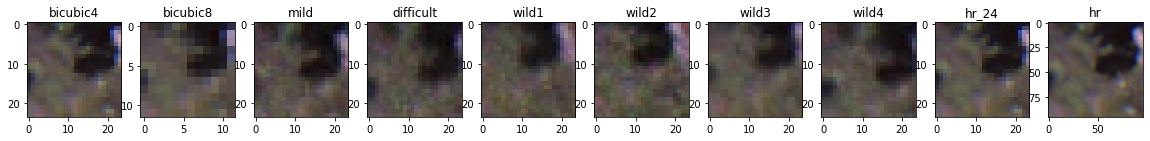

In [ ]:
#@title DIV2K dataset samples { run: "auto" }
image_index = 1 #@param {type: "slider", min: 1, max: 799}
image_size =  24#@param

bicubic4 = (plt.imread(f"/content/DIV2K_train_LR_x4/{image_index:04}.png")[:image_size, :image_size], "bicubic4")
bicubic8 = (plt.imread(f"/content/DIV2K_train_LR_x8/{image_index:04}x8.png")[:image_size//2, :image_size//2], "bicubic8")
mild = (plt.imread(f"/content/DIV2K_train_LR_mild/{image_index:04}x4m.png")[:image_size, :image_size], "mild")
difficult = (plt.imread(f"/content/DIV2K_train_LR_difficult/{image_index:04}x4d.png")[:image_size, :image_size], "difficult")
wild1 = (plt.imread(f"/content/DIV2K_train_LR_wild/{image_index:04}x4w1.png")[:image_size, :image_size], "wild1")
wild2 = (plt.imread(f"/content/DIV2K_train_LR_wild/{image_index:04}x4w2.png")[:image_size, :image_size], "wild2")
wild3 = (plt.imread(f"/content/DIV2K_train_LR_wild/{image_index:04}x4w3.png")[:image_size, :image_size], "wild3")
wild4 = (plt.imread(f"/content/DIV2K_train_LR_wild/{image_index:04}x4w4.png")[:image_size, :image_size], "wild4")
hr = (plt.imread(f"/content/DIV2K_train_HR/{image_index:04}.png")[:image_size * 4, :image_size * 4], "hr")
hr_res = (cv.resize(hr[0], (image_size, image_size)), "hr_24")

imgs = [bicubic4, bicubic8, mild, difficult, wild1, wild2, wild3, wild4, hr_res, hr]
plt.figure(figsize=(20, 8))
for i in range(len(imgs)):
  plt.subplot(1, len(imgs), i + 1)
  plt.imshow(imgs[i][0])
  plt.title(imgs[i][1])

In [ ]:
#@title Dataset
crop_type = "random" #@param ["center", "random"]
lr_version = "x4" #@param ["x4", "mild",  "difficult", "wild"]
patch_size = 24 #@param
use_canny = True #@param {type: "boolean"}
blur = False #@param {type: "boolean"}

def crop_images(images: Tuple[tf.Tensor], crop_type: str, scale: int, patch_size: int) -> List[tf.Tensor]:
  lr_shape = tf.shape(images[0])

  if crop_type == "center":
    start_x = (lr_shape[1] - patch_size) // 2
    start_y = (lr_shape[0] - patch_size) // 2
  else:
    start_x = tf.random.uniform(shape=(), maxval=lr_shape[1] - patch_size + 1, dtype=tf.int32)
    start_y = tf.random.uniform(shape=(), maxval=lr_shape[0] - patch_size + 1, dtype=tf.int32)

  cropped_images = []
  for index, image in enumerate(images):
    img_scale = 1 if index == 0 else scale
    size = patch_size * img_scale
    cropped_image = tf.image.crop_to_bounding_box(image, start_y * img_scale, start_x * img_scale, size, size)
    cropped_images.append(cropped_image)

  return cropped_images

def get_DIV2K_dataset(split: str = "train", lr_version: str = "wild", patch_size = 24, canny_version = False, batch_size: int = 64, crop_type = "center", blur = False) -> tf.data.Dataset:
  """
  Create a TensorFlow dataset from the DIV2K.
  `split` can be `train` or `valid` respectively for the train and validation sets.
  `version` can be `difficult`, `mild`, `wild`, `x8` and `x4` (bicubic).
  """
  if split not in ["train", "valid"]:
    raise Exception(split + " is not a valid split.")
  if lr_version not in ["difficult", "mild", "wild", "x8", "x4"]:
    raise Exception(lr_version + " is not a valid LR version.")

  LR_folder = f"DIV2K_{split}_LR_{lr_version}"
  HR_folder = f"DIV2K_{split}_HR"
  canny_folder = f"DIV2K_{split}_canny"

  lr_paths = sorted([os.path.join(LR_folder, element) for element in os.listdir(LR_folder)])
  hr_paths = sorted([os.path.join(HR_folder, element) for element in os.listdir(HR_folder)])

  if lr_version == "wild":
    # Repeat the hr paths 4 times
    hr_paths = sorted(hr_paths * 4)

  lr_dataset = load_image_dataset(lr_paths)
  lr_dataset = lr_dataset.map(lambda x: tf.cast(x, tf.float32) / 255., num_parallel_calls=tf.data.AUTOTUNE)

  hr_dataset = load_image_dataset(hr_paths)
  hr_dataset = hr_dataset.map(lambda x: (tf.cast(x, tf.float32) - 127.5) / 127.5, num_parallel_calls=tf.data.AUTOTUNE)

  scale = 4 if lr_version != "x8" else 8

  if canny_version:
    canny_paths = sorted([os.path.join(canny_folder, element) for element in os.listdir(canny_folder)])
    canny_dataset = load_image_dataset(canny_paths, channels = 1)
    canny_dataset = canny_dataset.map(lambda x: tf.cast(x, tf.float32) / 255.)
    
    ds = tf.data.Dataset.zip((lr_dataset, hr_dataset, canny_dataset))

    if patch_size:
      ds = ds.map(lambda lr, hr, canny: crop_images([lr, hr, canny], crop_type, scale, patch_size), num_parallel_calls=tf.data.AUTOTUNE)

    if blur:
      ds = ds.map(lambda lr, hr, canny: (tfa.image.median_filter2d(lr, (2, 2)), hr, canny))

    ds.file_paths = (lr_paths, hr_paths, canny_paths)
    return ds

  ds = tf.data.Dataset.zip((lr_dataset, hr_dataset))

  if patch_size:
    ds = ds.map(lambda lr, hr: crop_images([lr, hr], crop_type, scale, patch_size), num_parallel_calls=tf.data.AUTOTUNE)

  if blur:
    ds = ds.map(lambda lr, hr: (tfa.image.median_filter2d(lr, (2, 2)), hr))

  ds.file_paths = (lr_paths, hr_paths)
  return ds

train_dataset = get_DIV2K_dataset(split="train", lr_version=lr_version, patch_size=patch_size, crop_type=crop_type, canny_version=use_canny, blur=blur)
print("Loaded train dataset into train_dataset")
valid_dataset = get_DIV2K_dataset(split="valid", lr_version=lr_version, patch_size=patch_size, crop_type="center", canny_version=use_canny, blur=blur)
print("Loaded train dataset into valid_dataset")

Loaded train dataset into train_dataset
Loaded train dataset into valid_dataset


=== Inspect Dataset Format ===
LR Image Shape: (24, 24, 3)
LR Min value: 0.0
LR Max value: 1.0
HR Image Shape: (96, 96, 3)
HR Min value: -1.0
HR Max value: 1.0
Canny Image Shape: (96, 96, 1)
Canny Min value: 0.0
Canny Max value: 1.0



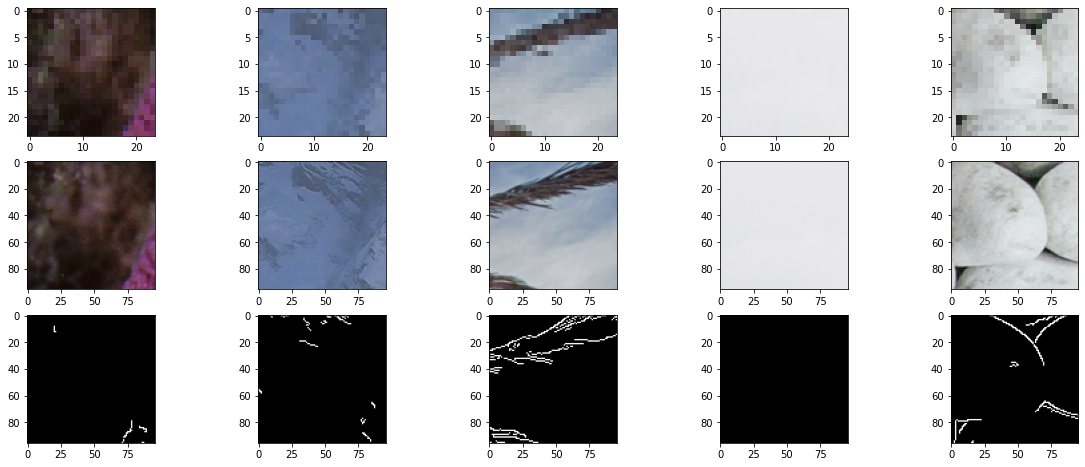

In [ ]:
#@title Dataset samples
names = ["LR", "HR", "Canny"]
sample = next(iter(train_dataset.batch(32)))

print("=== Inspect Dataset Format ===")

for index, images in enumerate(sample):
  print("{} Image Shape:".format(names[index]), images[0].shape)
  print("{} Min value:".format(names[index]), np.min(images))
  print("{} Max value:".format(names[index]), np.max(images))

print()

plt.figure(figsize=(20, 8))

for i, data in enumerate(train_dataset.take(5)):
  lr, hr = data[:2]
  is_canny = len(data) > 2
  rows = 3 if is_canny else 2

  plt.subplot(rows, 5, i + 1)
  plot_img_0_1(lr)

  plt.subplot(rows, 5, i + 6)
  plot_img_1_1(hr)

  if is_canny:
    plt.subplot(rows, 5, i + 11)
    plot_img_1_1(data[2][:, :, 0], cmap="gray")

plt.show()

## Dataset generation code

Code used to generate the bicubic x4 and canny versions of the DIV2K dataset.

In [ ]:
# @title Bicubic x4 dataset generation

def gen_bicubic_dataset(dataset, output_dir):
  lr_paths, hr_paths = dataset.file_paths

  if not os.path.exists(output_dir):
    os.mkdir(output_dir)

  i = 0
  for lr, hr in tqdm_notebook(dataset):
    height, width, _ = hr.shape
    new_size = (width // 4, height // 4)
    hr = cast_img_to_uint8(hr * 127.5 + 127.5)
    hr = cv.cvtColor(hr, cv.COLOR_RGB2BGR)
    resized = cv.resize(hr, new_size)
    path = os.path.join(output_dir, os.path.basename(hr_paths[i]))
    cv.imwrite(path, resized)
    i += 1

gen_bicubic_dataset(get_DIV2K_dataset(split="train", lr_version="x8", patch_size=None), "DIV2K_train_LR_x4")
gen_bicubic_dataset(get_DIV2K_dataset(split="valid", lr_version="x8", patch_size=None), "DIV2K_valid_LR_x4")

In [ ]:
# @title Canny dataset generation

def gen_canny_dataset(dataset, output_dir, th1=200, th2=300):
  lr_paths, hr_paths = dataset.file_paths

  if not os.path.exists(output_dir):
    os.mkdir(output_dir)

  i = 0
  for lr, hr in tqdm_notebook(dataset):
    canny = cv.Canny(cast_img_to_uint8(hr * 127.5 + 127.5), th1, th2)
    path = os.path.join(output_dir, os.path.basename(hr_paths[i]))
    cv.imwrite(path, canny)
    i += 1

gen_canny_dataset(get_DIV2K_dataset(split="train", lr_version="mild", patch_size=None), "DIV2K_train_canny")
gen_canny_dataset(get_DIV2K_dataset(split="valid", lr_version="mild", patch_size=None), "DIV2K_valid_canny")

## Super-Resolution Model

### Weights and Biases experiment settings

In [ ]:
#@title Initialization
!pip install wandb --upgrade -q --progress-bar off

import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#@title Start run
run_type = "Crashed run" #@param ["New run", "Crashed run", "Resume run"]
resume_run = run_type != "New run"

if resume_run:
  print("Insert the run id to resume: ")
  resume_run_id = input()

  wandb.init(id=resume_run_id, resume="must", project="cv-project", entity="dl-team")
else:
  wandb.init(project="cv-project", entity="dl-team")

Insert the run id to resume: 
2fty3q1g


wandb: Currently logged in as: skylion (dl-team). Use `wandb login --relogin` to force relogin


In [ ]:
#@title Hyper-parameters

epochs =   250#@param
batch_size = 16 #@param

#@markdown <br />

train_samples =  800#@param
validation_samples =  200#@param

#@markdown <br />

adversarial_loss_weight =  1e-3#@param
content_loss_weight = 1 #@param
canny_loss_weight = 1 #@param

#@markdown <br />

lr = 1e-5 #@param
gen_blocks = 16 #@param

#@markdown <br />

use_vgg = True #@param {type: "boolean"}
train_generator_only = False #@param {type: "boolean"}

#@markdown <br />

preload_generator = False #@param {type: "boolean"}
generator_run_id = "1jx12vcf" #@param {type: "string"}


# Prepare train and validate dataset
train_subset = train_dataset.take(train_samples).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_subset = valid_dataset.take(validation_samples).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Cache datasets
valid_subset = valid_subset.cache()

if crop_type == "center":
  train_subset = train_subset.cache()

  for _ in tqdm_notebook(train_subset, desc="Preprocess and cache train subset"):
    pass

for _ in tqdm_notebook(valid_subset, desc="Preprocess and cache valid subset"):
  pass

# Reload anc check run parameters

def check_value(current_value, config_key):
  if current_value != wandb.config[config_key]:
    print("⚠️ WARNING: Value of {} changed from {} to {}".format(config_key, wandb.config[config_key], current_value))
  return current_value

if wandb.run:
  if run_type == "New run":
    config = {
        "use_canny": use_canny,
        "crop_type":  crop_type,
        "patch_size": patch_size,
        "lr_version": lr_version,
        "epochs": epochs,
        "batch_size": batch_size,

        "train_samples": train_samples,
        "validation_samples": validation_samples,

        "content_loss_weight": content_loss_weight,
        "adversarial_loss_weight": adversarial_loss_weight,

        "learning_rate": lr,
        "gen_blocks": gen_blocks,
        "use_vgg": use_vgg,
        "train_generator_only": train_generator_only,
        "preload_generator": preload_generator,
        "generator_run_id": generator_run_id
    }

    if use_canny:
      config["canny_loss_weight"] = canny_loss_weight

    wandb.config.update(config)
  else:
    # Resume run or crash run
    use_canny = check_value(use_canny, "use_canny")
    crop_type = check_value(crop_type, "crop_type")
    patch_size = check_value(patch_size, "patch_size")
    lr_version = check_value(lr_version, "lr_version")

    batch_size = check_value(batch_size, "batch_size")
    
    train_samples = check_value(train_samples, "train_samples")
    validation_samples = check_value(validation_samples, "validation_samples")

    adversarial_loss_weight = check_value(adversarial_loss_weight, "adversarial_loss_weight")
    content_loss_weight = check_value(content_loss_weight, "content_loss_weight")

    if use_canny:
      canny_loss_weight = check_value(canny_loss_weight, "canny_loss_weight")

    lr = check_value(lr, "learning_rate")
    gen_blocks = check_value(gen_blocks, "gen_blocks")
    use_vgg = check_value(use_vgg, "use_vgg")
    train_generator_only = check_value(train_generator_only, "train_generator_only")
    preload_generator = check_value(preload_generator, "preload_generator")
    generator_run_id = check_value(generator_run_id, "generator_run_id")

    if run_type == "Resume run":
      wandb.config.update({ "epochs": epochs })
    else:
      epochs = check_value(epochs, "epochs")

Preprocess and cache valid subset:   0%|          | 0/7 [00:00<?, ?it/s]

⚠️ WARNING: Value of learning_rate changed from 0.0001 to 1e-05
⚠️ WARNING: Value of preload_generator changed from True to False


### Model creation

In [ ]:
#@title MySubpixelConv2D

#@markdown Upsampling layer used to reduce checkboard artifacts.

class MySubpixelConv2D(Layer):
  def __init__(self, upsampling_factor=4, **kwargs):
    super().__init__(**kwargs)
    self.upsampling_factor = upsampling_factor

  def call(self, inputs):
    return tf.nn.depth_to_space(inputs, self.upsampling_factor)

  def get_config(self):
    return {"upsampling_factor": self.upsampling_factor}

In [ ]:
#@title SuperResolutionGAN

class SuperResolutionGAN(tf.keras.Model):
  def __init__(self, content_loss_weight, adversarial_loss_weight, lr, gen_blocks, use_vgg, train_generator_only, hr_shape=(96, 96, 3), generator=None, discriminator=None):
    super(SuperResolutionGAN, self).__init__()

    # Define optimizers
    self.generator_optimizer = tf.keras.optimizers.Adam(lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)

    self.generator = generator or self.__make_generator(gen_blocks)
    self.discriminator = discriminator or self.__make_discriminator(hr_shape)

    # Define loss
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
    self.mse = tf.keras.losses.MeanSquaredError()

    self.content_loss_weight = content_loss_weight
    self.adversarial_loss_weight = adversarial_loss_weight
    self.lr = lr
    self.hr_shape = hr_shape
    self.gen_blocks = gen_blocks
    self.use_vgg = use_vgg
    self.train_generator_only = train_generator_only

    if use_vgg:
      vgg19 = tf.keras.applications.vgg19.VGG19(input_shape=(None, None, 3), include_top=False)
      self.vgg = tf.keras.models.Model(vgg19.input, vgg19.layers[20].output)

  def __make_generator(self, gen_blocks):
    inputs = tf.keras.Input(shape=(None, None, 3))
    x = Conv2D(64, (9, 9), strides=(1, 1), padding="same")(inputs)
    x_begin = PReLU(shared_axes=[1, 2])(x)
    x = x_begin

    def res_block(input):
      x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(input)
      x = BatchNormalization(momentum=.8)(x)
      x = PReLU(shared_axes=[1, 2])(x)
      x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
      x = BatchNormalization(momentum=.8)(x)
      return Add()((input, x))

    for _ in range(gen_blocks):
      x = res_block(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()((x_begin, x))

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = PReLU(shared_axes=[1, 2])(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = MySubpixelConv2D(upsampling_factor=2)(x)
    x = PReLU(shared_axes=[1, 2])(x)

    x = Conv2D(3, (9, 9), strides=(1, 1), padding="same", activation="tanh")(x)

    model = tf.keras.Model(inputs, x, name="generator")
    model.compile(optimizer=self.generator_optimizer)

    return model

  def __make_discriminator(self, input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(inputs)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Flatten()(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=.2)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, x, name="discriminator")
    model.compile(optimizer=self.discriminator_optimizer)

    return model
  
  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  def content_loss(self, hr, generated_images):
    if not self.use_vgg:
      return self.mse(hr, generated_images)

    hr = tf.keras.applications.vgg19.preprocess_input(hr * 127.5 + 127.5)
    sr = tf.keras.applications.vgg19.preprocess_input(generated_images * 127.5 + 127.5)
    hr_features = self.vgg(hr) / 12.75
    sr_features = self.vgg(sr) / 12.75
    return self.mse(hr_features, sr_features)

  def train_step(self, data):
    lr, hr = data

    if self.train_generator_only:
      with tf.GradientTape() as gen_tape:
        generated_images = self(lr, training=True)

        # Compute generator loss
        content_loss = self.content_loss_weight * self.content_loss(hr, generated_images)

      gradients_of_generator = gen_tape.gradient(content_loss, self.generator.trainable_variables)
      self.generator.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

      psnr = tf.reduce_mean(tf.image.psnr(generated_images, hr, max_val=2.0))
      ssim = tf.reduce_mean(tf.image.ssim(generated_images, hr, max_val=2.0))

      return {"ssim": ssim, "psnr": psnr, "total_loss": content_loss, "content_loss": content_loss}
    else:
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = self(lr, training=True)
        
        real_output = self.discriminator(hr, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        # Compute generator loss
        adv_gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
        content_loss = self.content_loss_weight * self.content_loss(hr, generated_images)
        gen_loss = content_loss + adv_gen_loss

        adv_disc_loss = self.discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(adv_disc_loss, self.discriminator.trainable_variables)

      self.generator.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      total_loss = gen_loss + adv_disc_loss

      psnr = tf.reduce_mean(tf.image.psnr(generated_images, hr, max_val=2.0))
      ssim = tf.reduce_mean(tf.image.ssim(generated_images, hr, max_val=2.0))

      return {"ssim": ssim, "psnr": psnr, "total_loss": total_loss, "adv_gen_loss": adv_gen_loss, "adv_disc_loss": adv_disc_loss, "gen_loss": gen_loss, "content_loss": content_loss}

  def call(self, lr, training=False):
    return self.generator(lr, training=training)

  def test_step(self, data):
    lr, hr = data
    generated_images = self(lr, training=False)

    if not self.train_generator_only:
      real_output = self.discriminator(hr, training=False)
      fake_output = self.discriminator(generated_images, training=False)
      adv_gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)

    # Compute generator loss
    content_loss = self.content_loss_weight * self.content_loss(hr, generated_images)

    if not self.train_generator_only:
      adv_disc_loss = self.discriminator_loss(real_output, fake_output)
      gen_loss = content_loss + adv_gen_loss
      total_loss = gen_loss + adv_disc_loss

    psnr = tf.reduce_mean(tf.image.psnr(generated_images, hr, max_val=2.0))
    ssim = tf.reduce_mean(tf.image.ssim(generated_images, hr, max_val=2.0))

    if self.train_generator_only:
      return {"ssim": ssim, "psnr": psnr, "total_loss": content_loss, "content_loss": content_loss}
    
    return {"ssim": ssim, "psnr": psnr, "total_loss": total_loss, "adv_gen_loss": adv_gen_loss, "adv_disc_loss": adv_disc_loss, "gen_loss": gen_loss, "content_loss": content_loss}

  def save(self, dirpath=".", suffix=""):
    if suffix:
      suffix = "-" + suffix
    model.generator.save(os.path.join(dirpath, "generator" + suffix + ".h5"))
    model.discriminator.save(os.path.join(dirpath, "discriminator" + suffix + ".h5"))

  def get_config(self):
    return {
        "discriminator": self.discriminator,
        "generator": self.generator,
        "content_loss_weight": self.content_loss_weight,
        "adversarial_loss_weight": self.adversarial_loss_weight,
        "lr": self.lr,
        "hr_shape": self.hr_shape,
        "gen_blocks": self.gen_blocks,
        "use_vgg": self.use_vgg,
        "train_generator_only": self.train_generator_only
        }

In [ ]:
#@title SuperResolutionCannyGAN

class SuperResolutionCannyGAN(tf.keras.Model):
  def __init__(self, content_loss_weight, adversarial_loss_weight, canny_loss_weight, lr, gen_blocks, use_vgg, train_generator_only, hr_shape=(96, 96, 3), generator=None, discriminator=None):
    super(SuperResolutionCannyGAN, self).__init__()

    # Define optimizers
    self.generator_optimizer = tf.keras.optimizers.Adam(lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)

    self.generator = self.__make_generator(generator, gen_blocks)
    self.discriminator = discriminator or self.__make_discriminator(hr_shape)

    # Define loss
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
    self.mse = tf.keras.losses.MeanSquaredError()

    self.content_loss_weight = content_loss_weight
    self.adversarial_loss_weight = adversarial_loss_weight
    self.canny_loss_weight = canny_loss_weight
    self.lr = lr
    self.hr_shape = hr_shape
    self.gen_blocks = gen_blocks
    self.use_vgg = use_vgg
    self.train_generator_only = train_generator_only

    if use_vgg:
      vgg19 = tf.keras.applications.vgg19.VGG19(input_shape=(None, None, 3), include_top=False)
      self.vgg = tf.keras.models.Model(vgg19.input, vgg19.layers[20].output)

  def __make_generator(self, generator, gen_blocks):
    if generator is None:
      inputs = tf.keras.Input(shape=(None, None, 3))
      x = Conv2D(64, (9, 9), strides=(1, 1), padding="same")(inputs)
      x_begin = PReLU(shared_axes=[1, 2])(x)
      x = x_begin

      def res_block(input):
        x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(input)
        x = BatchNormalization(momentum=.8)(x)
        x = PReLU(shared_axes=[1, 2])(x)
        x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
        x = BatchNormalization(momentum=.8)(x)
        return Add()((input, x))

      for _ in range(gen_blocks):
        x = res_block(x)

      x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)
      x = BatchNormalization()(x)
      x = Add()((x_begin, x))

      x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
      x = MySubpixelConv2D(upsampling_factor=2)(x)
      x = PReLU(shared_axes=[1, 2])(x)

      x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
      x = MySubpixelConv2D(upsampling_factor=2)(x)
      last = PReLU(shared_axes=[1, 2])(x)

      sr = Conv2D(3, (9, 9), strides=(1, 1), padding="same", activation="tanh")(last)
    else:
      if len(generator.layers) == 110:
        return generator
      else:
        inputs = generator.inputs
        sr = generator.layers[-1].output
        last = generator.layers[-2].output
    
    edges = Conv2D(1, (9, 9), strides=(1, 1), padding="same", activation="sigmoid", name="edges")(last)

    model = tf.keras.Model(inputs, [sr, edges], name="generator")
    model.compile(optimizer=self.generator_optimizer)

    return model

  def __make_discriminator(self, input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(inputs)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization(momentum=.8)(x)
    x = LeakyReLU(alpha=.2)(x)

    x = Flatten()(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=.2)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, x, name="discriminator")
    model.compile(optimizer=self.discriminator_optimizer)

    return model
  
  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  def content_loss(self, hr, generated_images):
    if not self.use_vgg:
      return self.mse(hr, generated_images)

    hr = tf.keras.applications.vgg19.preprocess_input(hr * 127.5 + 127.5)
    sr = tf.keras.applications.vgg19.preprocess_input(generated_images * 127.5 + 127.5)
    hr_features = self.vgg(hr) / 12.75
    sr_features = self.vgg(sr) / 12.75
    return self.mse(hr_features, sr_features)

  def canny_loss(self, canny, generated_canny):
    return self.cross_entropy(canny, generated_canny)

  def train_step(self, data):
    lr, hr, canny = data

    if self.train_generator_only:
      with tf.GradientTape() as gen_tape:
        generated_images, generated_canny = self(lr, training=True)
        
        # Compute generator loss
        content_loss = self.content_loss_weight * self.content_loss(hr, generated_images)
        canny_loss = self.canny_loss_weight * self.canny_loss(canny, generated_canny)

        total_loss = content_loss + canny_loss
      
      gradients_of_generator = gen_tape.gradient(total_loss, self.generator.trainable_variables)
      self.generator.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

      psnr = tf.reduce_mean(tf.image.psnr(generated_images, hr, max_val=2.0))
      ssim = tf.reduce_mean(tf.image.ssim(generated_images, hr, max_val=2.0))

      return {"ssim": ssim, "psnr": psnr, "total_loss": total_loss, "content_loss": content_loss, "canny_loss": canny_loss}
    else:
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images, generated_canny = self(lr, training=True)
        
        real_output = self.discriminator(hr, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        # Compute generator loss
        adv_gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)
        content_loss = self.content_loss_weight * self.content_loss(hr, generated_images)
        canny_loss = self.canny_loss_weight * self.canny_loss(canny, generated_canny)

        gen_loss = content_loss + adv_gen_loss + canny_loss

        adv_disc_loss = self.discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(adv_disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      total_loss = gen_loss + adv_disc_loss

      psnr = tf.reduce_mean(tf.image.psnr(generated_images, hr, max_val=2.0))
      ssim = tf.reduce_mean(tf.image.ssim(generated_images, hr, max_val=2.0))

      return {"ssim": ssim, "psnr": psnr, "total_loss": total_loss, "adv_gen_loss": adv_gen_loss, "adv_disc_loss": adv_disc_loss, "gen_loss": gen_loss, "content_loss": content_loss, "canny_loss": canny_loss}

  def call(self, lr, training=False):
    return self.generator(lr, training=training)

  def test_step(self, data):
    lr, hr, canny = data
    generated_images, generated_canny = self(lr, training=False)

    if not self.train_generator_only:
      real_output = self.discriminator(hr, training=False)
      fake_output = self.discriminator(generated_images, training=False)
      adv_gen_loss = self.adversarial_loss_weight * self.generator_loss(fake_output)

    # Compute generator loss
    content_loss = self.content_loss_weight * self.content_loss(hr, generated_images)
    canny_loss = self.canny_loss_weight * self.canny_loss(canny, generated_canny)

    if not self.train_generator_only:
      adv_disc_loss = self.discriminator_loss(real_output, fake_output)
      gen_loss = content_loss + adv_gen_loss + canny_loss
      total_loss = gen_loss + adv_disc_loss
    else:
      total_loss = content_loss + canny_loss
    
    psnr = tf.reduce_mean(tf.image.psnr(generated_images, hr, max_val=2.0))
    ssim = tf.reduce_mean(tf.image.ssim(generated_images, hr, max_val=2.0))

    if self.train_generator_only:
      return {"ssim": ssim, "psnr": psnr, "total_loss": total_loss, "content_loss": content_loss, "canny_loss": canny_loss}
    
    return {"ssim": ssim, "psnr": psnr, "total_loss": total_loss, "adv_gen_loss": adv_gen_loss, "adv_disc_loss": adv_disc_loss, "gen_loss": gen_loss, "content_loss": content_loss, "canny_loss": canny_loss}

  def save(self, dirpath=".", suffix=""):
    if suffix:
      suffix = "-" + suffix
    model.generator.save(os.path.join(dirpath, "generator" + suffix + ".h5"))
    model.discriminator.save(os.path.join(dirpath, "discriminator" + suffix + ".h5"))

  def get_config(self):
    return {
        "discriminator": self.discriminator,
        "generator": self.generator,
        "content_loss_weight": self.content_loss_weight,
        "adversarial_loss_weight": self.adversarial_loss_weight,
        "canny_loss_weight": self.canny_loss_weight,
        "lr": self.lr,
        "hr_shape": self.hr_shape,
        "gen_blocks": self.gen_blocks,
        "use_vgg": self.use_vgg,
        "train_generator_only": self.train_generator_only
      }

In [ ]:
#@title Create model

if run_type == "New run":
  # Preload generator
  if preload_generator:
    generator_path = wandb.restore("generator-latest.h5", run_path="dl-team/cv-project/" + generator_run_id, replace=True)
    generator = tf.keras.models.load_model(generator_path.name, custom_objects={"MySubpixelConv2D": MySubpixelConv2D})
  else:
    generator = None

  # Create model
  if use_canny:
    model = SuperResolutionCannyGAN(generator=generator, hr_shape=(96, 96, 3), adversarial_loss_weight=adversarial_loss_weight, content_loss_weight=content_loss_weight, canny_loss_weight=canny_loss_weight, lr=lr, gen_blocks=gen_blocks, train_generator_only=train_generator_only, use_vgg=use_vgg)
  else:
    model = SuperResolutionGAN(generator=generator, hr_shape=(96, 96, 3), adversarial_loss_weight=adversarial_loss_weight, content_loss_weight=content_loss_weight, lr=lr, gen_blocks=gen_blocks, train_generator_only=train_generator_only, use_vgg=use_vgg)
  
  model.compile()

  # Save architecture plots and graph on wandb
  _ = tf.keras.utils.plot_model(model.generator, show_shapes=True, expand_nested=True, show_layer_activations=True, to_file="generator.png")
  _ = tf.keras.utils.plot_model(model.discriminator, show_shapes=True, expand_nested=True, show_layer_activations=True, to_file="discriminator.png")

  if wandb.run:
    wandb.log({"generator_arch": wandb.Image("generator.png"), "discriminator_arch": wandb.Image("discriminator.png")}, commit=False)
    wandb.log({"generator": wandb.Graph.from_keras(model.generator), "discriminator": wandb.Graph.from_keras(model.discriminator)}, commit=False)
else:
  # Resume model from wandb
  model = load_model_from_wandb(wandb.run.path, "latest")
  
  model.adversarial_loss_weight = adversarial_loss_weight
  model.content_loss_weight = content_loss_weight
  model.adversarial_loss_weight = adversarial_loss_weight
  model.lr = lr
  model.gen_blocks = gen_blocks
  model.use_vgg = use_vgg
  model.train_generator_only = train_generator_only

80150528/80134624 [==============================] - 0s 0us/step


### Callbacks

In [ ]:
#@title LogImagesCallback

# Retrieve some images from train and valid datasets
images = list(train_subset.unbatch().take(5)) + list(valid_subset.unbatch().take(5))

class LogImagesCallback(tf.keras.callbacks.Callback):
  def __init__(self, images, use_canny):
    self.images = images
    self.input = []
    self.use_canny = use_canny
    
    wandb_lr_images = []
    wandb_hr_images = []
    wandb_canny_images = []

    for data in self.images:
      lr, hr = data[0:2]
      self.input.append(lr)

      wandb_lr_images.append(wandb.Image(lr * 255.))
      wandb_hr_images.append(wandb.Image(hr * 127.5 + 127.5))

      if self.use_canny:
        wandb_canny_images.append(wandb.Image(data[2] * 255.))
    
    if not wandb.run.resumed:
      log_data = {"low resolution": wandb_lr_images, "high resolution": wandb_hr_images}
      
      if self.use_canny:
        log_data["canny"] = wandb_canny_images
      
      wandb.log(log_data, commit=False)

    self.input = np.array(self.input)
    self.video_data = []

  def on_epoch_end(self, epoch, logs=None):
    if self.use_canny:
      predictions, pred_canny = self.model.generator.predict(self.input)

      wandb_predictions = [wandb.Image(x * 255.) for x in pred_canny]
      wandb.log({"canny predictions": wandb_predictions}, commit=False)
    else:
      predictions = self.model.generator.predict(self.input)

    wandb_predictions = [wandb.Image(predicted * 127.5 + 127.5) for predicted in predictions]
    wandb.log({"predictions": wandb_predictions}, commit=False)

    # Train animation code
    lr, hr = self.images[0][0:2]
    
    num_images = len(self.images[0]) + 1

    fig = plt.figure(figsize=(10, 8))
    plt.suptitle("Epoch: {:03}".format(epoch))
    plt.subplot(1, num_images, 1)
    plot_img_0_1(lr)
    plt.axis("off")

    plt.subplot(1, num_images, 2)
    plot_img_1_1(hr)
    plt.axis("off")

    plt.subplot(1, num_images, 3)
    plot_img_1_1(predictions[0])
    plt.axis("off")

    if self.use_canny:
      plt.subplot(1, num_images, 4)
      plot_img_0_1(pred_canny[0][:, :, 0])
      plt.axis("off")

    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    self.video_data.append(data)

    plt.close(fig)

    if epoch == self.params["epochs"] - 1:
      data = np.transpose(np.array(self.video_data), (0, 3, 1, 2))
      wandb.log({"train_anim": wandb.Video(data, format="mp4")}, commit=False)

In [ ]:
#@title WandbModelCheckpoint

class WandbModelCheckpoint(tf.keras.callbacks.Callback):
  def __init__(self, monitor):
    self.monitor = monitor

    self.best = float("inf")

    previous_best = wandb.run.summary.get("best_" + self.monitor)
    if previous_best is not None:
      self.best = previous_best

  def on_epoch_end(self, epoch, logs={}):
    # Save checkpoint for current epoch
    self.model.save(wandb.run.dir, suffix="latest")

    wandb.save(os.path.join(wandb.run.dir, "generator-latest.h5"), base_path=wandb.run.dir, policy="now")
    wandb.save(os.path.join(wandb.run.dir, "discriminator-latest.h5"), base_path=wandb.run.dir, policy="now")

    # Save new best
    current = logs.get(self.monitor)

    if current > self.best:
      self.model.save(wandb.run.dir, suffix="best")

      wandb.save(os.path.join(wandb.run.dir, "generator-best.h5"), base_path=wandb.run.dir, policy="now")
      wandb.save(os.path.join(wandb.run.dir, "discriminator-best.h5"), base_path=wandb.run.dir, policy="now")

      self.best = current

In [ ]:
callbacks = [
  WandbModelCheckpoint(monitor="val_psnr"),
  LogImagesCallback(images, use_canny),
  wandb.keras.WandbCallback(monitor="val_psnr", mode="max", save_model=False, save_graph=False)
]

### Model Fit

In [ ]:
initial_epoch = wandb.run.summary.get("epoch") + 1 if wandb.run.resumed else 0
history = model.fit(train_subset, validation_data=valid_subset, initial_epoch=initial_epoch, epochs=epochs, callbacks=callbacks, shuffle=True)

Epoch 241/250
50/50 [==============================] - 115s 2s/step - ssim: 0.6080 - psnr: 24.0119 - total_loss: 0.4555 - adv_gen_loss: 0.0060 - adv_disc_loss: 0.1798 - gen_loss: 0.2758 - content_loss: 0.1079 - canny_loss: 0.1618 - val_ssim: 0.5475 - val_psnr: 20.7267 - val_total_loss: 2.4922 - val_adv_gen_loss: 1.9298e-04 - val_adv_disc_loss: 1.9762 - val_gen_loss: 0.5159 - val_content_loss: 0.2216 - val_canny_loss: 0.2941 - _timestamp: 1653637300.0000 - _runtime: 25243.0000
Epoch 242/250
50/50 [==============================] - 86s 2s/step - ssim: 0.6052 - psnr: 24.3036 - total_loss: 0.5745 - adv_gen_loss: 0.0063 - adv_disc_loss: 0.3004 - gen_loss: 0.2741 - content_loss: 0.1031 - canny_loss: 0.1647 - val_ssim: 0.5474 - val_psnr: 21.0985 - val_total_loss: 3.9947 - val_adv_gen_loss: 0.0035 - val_adv_disc_loss: 3.4596 - val_gen_loss: 0.5351 - val_content_loss: 0.2358 - val_canny_loss: 0.2958 - _timestamp: 1653637422.0000 - _runtime: 25365.0000
Epoch 243/250
50/50 [======================

In [ ]:
#@title End wandb run
wandb.finish()

adv_disc_loss,█▁▁▃▁▁▁▂▃▁
adv_gen_loss,▁█▆▄▄▆▇▃▄▆
canny_loss,█▆▄▁▄▅▄▁▂█
content_loss,█▃▇▁▆▆▇▁█▄
epoch,▁▂▃▃▄▅▆▆▇█
gen_loss,█▅▆▁▅▆▆▁▄▇
psnr,▁▅▄▇▅▃▃▄█▄
ssim,▂▅▄▆▄▁▄▄█▃
total_loss,█▂▂▂▂▂▂▁▃▃
val_adv_disc_loss,▃▆▂▆▃█▁▄▂▁
val_adv_gen_loss,▁▇▃▃▁█▄▃▇▄


### Evaluation

In [ ]:
#@title Load test dataset

def get_test_dataset(name: str) -> tf.data.Dataset:
  if name not in ["BSD100", "Set14", "Set5"]:
    raise Exception(name + " is not a valid dataset.")

  folder = f"./{name}/image_SRF_4"

  lr_paths = []
  hr_paths = []
  for element in os.listdir(folder):
    path = os.path.join(folder, element)

    if "LR" in element:
      lr_paths.append(path)
    else:
      hr_paths.append(path)

  lr_paths = sorted(lr_paths)
  hr_paths = sorted(hr_paths)

  lr_dataset = load_image_dataset(lr_paths)
  lr_dataset = lr_dataset.map(lambda x: tf.cast(x, tf.float32) / 255., num_parallel_calls=tf.data.AUTOTUNE)

  hr_dataset = load_image_dataset(hr_paths)
  hr_dataset = hr_dataset.map(lambda x: (tf.cast(x, tf.float32) - 127.5) / 127.5, num_parallel_calls=tf.data.AUTOTUNE)

  ds = tf.data.Dataset.zip((lr_dataset, hr_dataset))
  ds.file_paths = (lr_paths, hr_paths)

  return ds

set5_dataset = get_test_dataset("Set5")
set14_dataset = get_test_dataset("Set14")
bsd100_dataset = get_test_dataset("BSD100")

print("Loaded Set5 with", len(set5_dataset), "images")
print("Loaded Set14 with", len(set14_dataset), "images")
print("Loaded BSD100 with", len(bsd100_dataset), "images")

Loaded Set5 with 5 images
Loaded Set14 with 14 images
Loaded BSD100 with 100 images


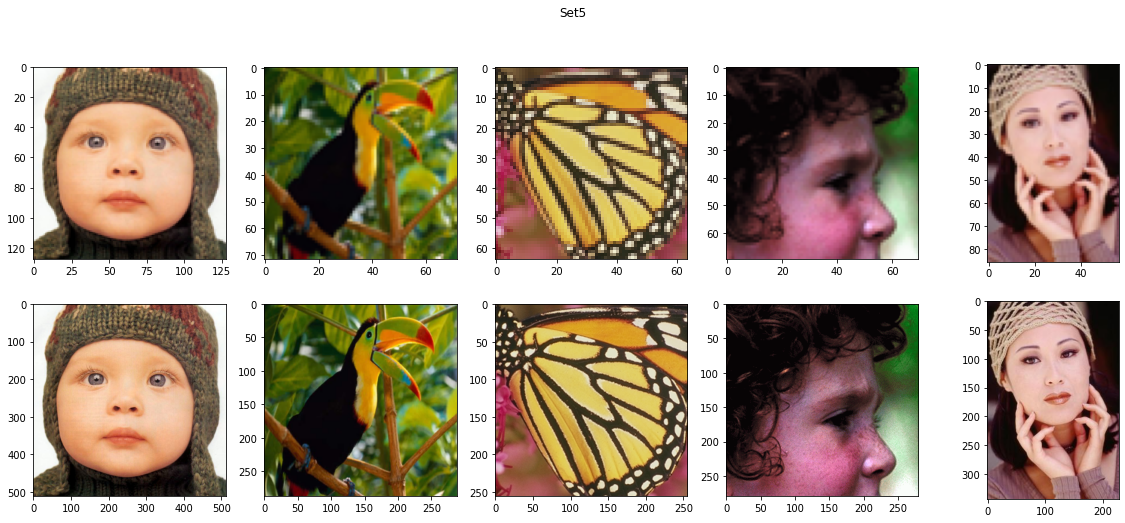

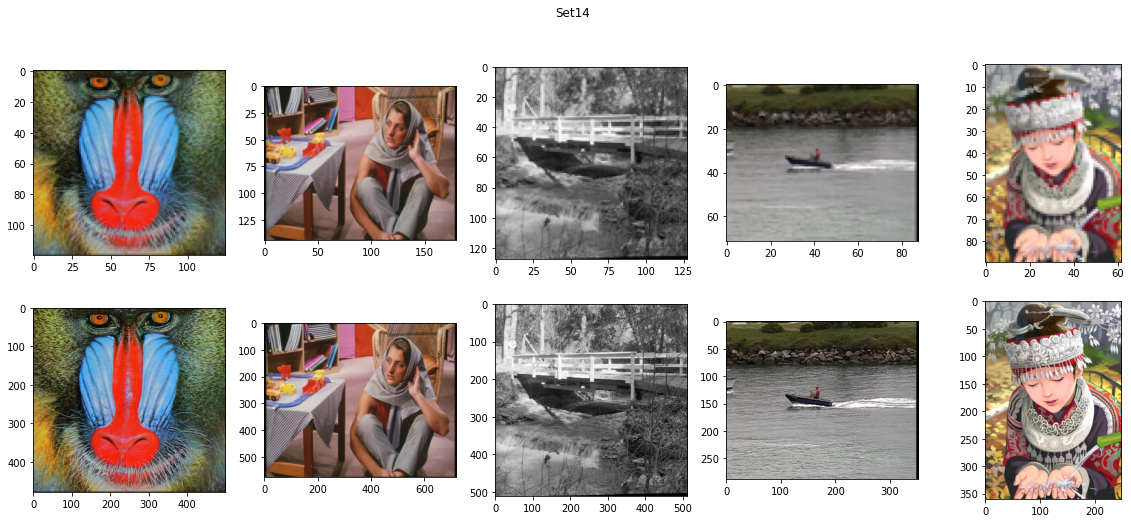

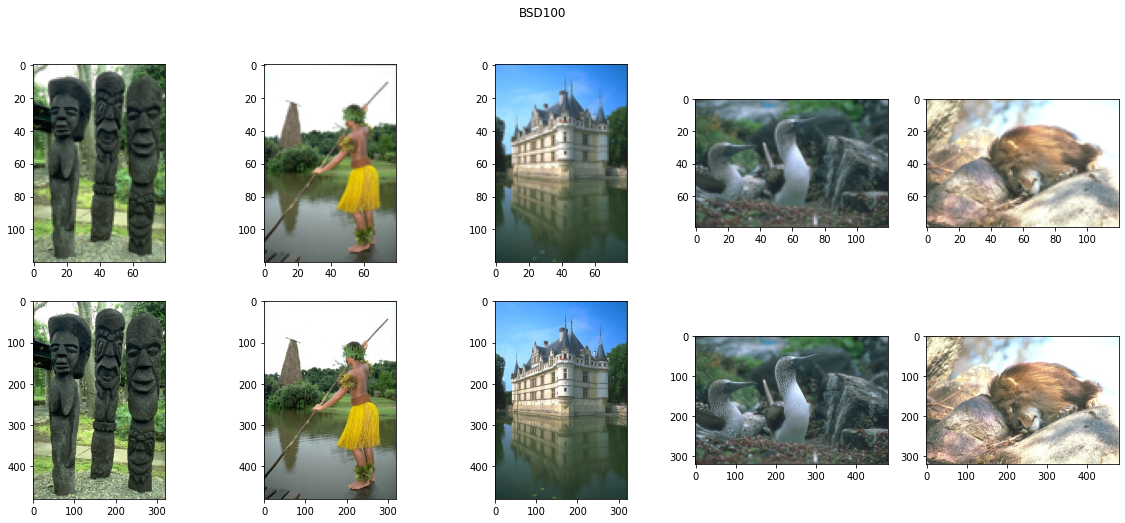

In [ ]:
#@title Test dataset samples
def show_samples(name, ds):
  plt.figure(figsize=(20, 8))
  plt.suptitle(name)

  for i, data in enumerate(ds.take(5)):
    lr, hr = data[:2]
    is_canny = len(data) > 2
    rows = 3 if is_canny else 2

    plt.subplot(rows, 5, i + 1)
    plot_img_0_1(lr)

    plt.subplot(rows, 5, i + 6)
    plot_img_1_1(hr)

    if is_canny:
      plt.subplot(rows, 5, i + 11)
      plot_img_1_1(data[2][:, :, 0], cmap="gray")

  plt.show()

show_samples("Set5", set5_dataset)
print("")
show_samples("Set14", set14_dataset)
print("")
show_samples("BSD100", bsd100_dataset)

In [ ]:
!rm -r results

In [ ]:
#@title Load pretrained model

pretrained_models_drive_id = {
    "SRRESNET": "1m6D9Ia8dwrc7dQzh7P5omNIIeshQ9oAt",
    "SRGAN-VGG22": "1lV8ueCgntdVNPqtH6RP7lANatwWHD2jh", 
    "SRGAN-VGG54": "1p-ln9uqGPtyszjFdnwP8DwO18RHMZWQu", 
    "SRRESNET-CANNY": "1gIUBH611yuZXzEI29-7sC0Eei5AsdqpM",
    "SRGAN-CANNY-VGG54": "1H3hTleGiNYOB-mhNGTCPWixbKujxc1A2",
    "SRGAN-CANNY-VGG54-CANNY-GENERATOR": "1Zfy3eLc8aYby05XzFhKT_5T5tTsbEYxo",
}

model_name = "SRGAN-CANNY-VGG54" #@param ["SRRESNET", "SRGAN-VGG22", "SRGAN-VGG54", "SRRESNET-CANNY", "SRGAN-CANNY-VGG54", "SRGAN-CANNY-VGG54-CANNY-GENERATOR"]
is_canny = "CANNY" in model_name

gdrive_id = pretrained_models_drive_id[model_name]
download_dataset(model_name + ".h5", gdrive_id, unzip=False)
loaded_model = tf.keras.models.load_model(model_name + ".h5", custom_objects={"MySubpixelConv2D": MySubpixelConv2D})
print("Loaded model", model_name, "into the variable loaded_model")

Loaded model SRGAN-CANNY-VGG54 into the variable loaded_model


In [ ]:
#@title Save results

def save_results(dataset, output, names=None, is_canny=False):
  output_names = ["SR", "canny"]
  mse = tf.keras.losses.MeanSquaredError()

  metrics = {}

  if not os.path.exists(output):
    os.mkdir(output)

  for i, (lr, hr) in enumerate(tqdm_notebook(dataset, desc="Saving into " + output)):
    image_name = names[i] if names is not None else "{:03d}".format(i)
    name = os.path.join(output, image_name)

    image_metrics = {}

    save_img_0_1(name + "_LR.png", lr)
    save_img_1_1(name + "_HR.png", hr)
    batch_hr = tf.expand_dims(hr, axis=0)

    opencv_lr = (lr.numpy() * 255.).astype(np.uint8)
    bicubic = cv.resize(opencv_lr, (opencv_lr.shape[1] * 4, opencv_lr.shape[0] * 4), interpolation = cv.INTER_CUBIC)
    save_img(name + "_bicubic.png", bicubic)
    
    batch_bicubic = tf.expand_dims((tf.cast(bicubic, tf.float32) - 127.5) / 127.5, axis=0)
    image_metrics["PSNR-bicubic"] = tf.image.psnr(batch_bicubic, batch_hr, max_val=2.0)[0].numpy()
    image_metrics["SSIM-bicubic"] = tf.image.ssim(batch_bicubic, batch_hr, max_val=2.0)[0].numpy()
    image_metrics["MSE-bicubic"] = mse(batch_hr, batch_bicubic).numpy()

    if is_canny:
      opencv_hr = (hr.numpy() * 127.5 + 127.5).astype(np.uint8)
      canny = cv.Canny(opencv_hr, 200, 300)
      save_img(name + "_canny_gt.png", canny, cmap="gray")
      batch_norm_canny = tf.expand_dims((canny - 127.5) / 127.5, axis=0)
    
    predictions = loaded_model(tf.expand_dims(lr, axis=0))
    for pred_index, prediction in enumerate(predictions):
      output_name = output_names[pred_index]

      if pred_index == 0:
        image_metrics["PSNR-SR"] = tf.image.psnr(prediction, batch_hr, max_val=2.0)[0].numpy()
        image_metrics["SSIM-SR"] = tf.image.ssim(prediction, batch_hr, max_val=2.0)[0].numpy()
        image_metrics["MSE-SR"] = mse(batch_hr, prediction).numpy()
        save_img_1_1("{}_{}.png".format(name, output_name), tf.squeeze(prediction))
      elif pred_index == 1:
        image_metrics["MSE-canny"] = mse(batch_norm_canny, prediction).numpy()
        save_img_1_1("{}_{}.png".format(name, output_name), tf.squeeze(prediction), cmap="gray")
      
    metrics[image_name] = image_metrics
  
  return metrics

if not os.path.exists("results"):
  os.mkdir("results")

set5_metrics = save_results(set5_dataset, os.path.join("results", "Set5"), names=["baby", "bird", "butterfly", "head", "woman"], is_canny=is_canny)
set14_metrics = save_results(set14_dataset, os.path.join("results", "Set14"), names=["baboon", "barbara", "bridge", "coastguard", "comic", "face", "flowers", "foreman", "lenna", "man", "monarch", "pepper", "ppt3", "zebra"], is_canny=is_canny)
bsd100_metrics = save_results(bsd100_dataset, os.path.join("results", "BSD100"), is_canny=is_canny)

set5_df = pd.DataFrame(set5_metrics).transpose()
set14_df = pd.DataFrame(set14_metrics).transpose()
bsd100_df = pd.DataFrame(bsd100_metrics).transpose()

metrics = {"Set5": set5_df.mean(), "Set14": set14_df.mean(), "BSD100": bsd100_df.mean()}
metrics_df = pd.DataFrame(metrics).transpose()
metrics_df.columns = ["Avg " + col for col in metrics_df.columns]

metrics_df.to_csv("validation_metrics.csv")

metrics_df

Saving into results/Set5:   0%|          | 0/5 [00:00<?, ?it/s]

Saving into results/Set14:   0%|          | 0/14 [00:00<?, ?it/s]

Saving into results/BSD100:   0%|          | 0/100 [00:00<?, ?it/s]

,Avg PSNR-bicubic,Avg SSIM-bicubic,Avg MSE-bicubic,Avg PSNR-SR,Avg SSIM-SR,Avg MSE-SR,Avg MSE-canny
Set5,26.890461,0.758779,0.011412,25.451839,0.698077,0.013383,1.042540
Set14,24.370880,0.652288,0.017699,23.543245,0.582037,0.020506,1.037757
BSD100,24.743130,0.629582,0.017157,23.758783,0.554139,0.020354,1.031049


In [ ]:
#@title Zip results

!zip -rq {model_name}_best.zip results validation_metrics.csv

  0%|          | 0/6 [00:00<?, ?it/s]

SRRESNET.h5 already downloaded.
SRGAN-VGG22.h5 already downloaded.
SRGAN-VGG54.h5 already downloaded.
SRRESNET-CANNY.h5 already downloaded.
SRGAN-CANNY-VGG54.h5 already downloaded.
SRGAN-CANNY-VGG54-CANNY-GENERATOR.h5 already downloaded.


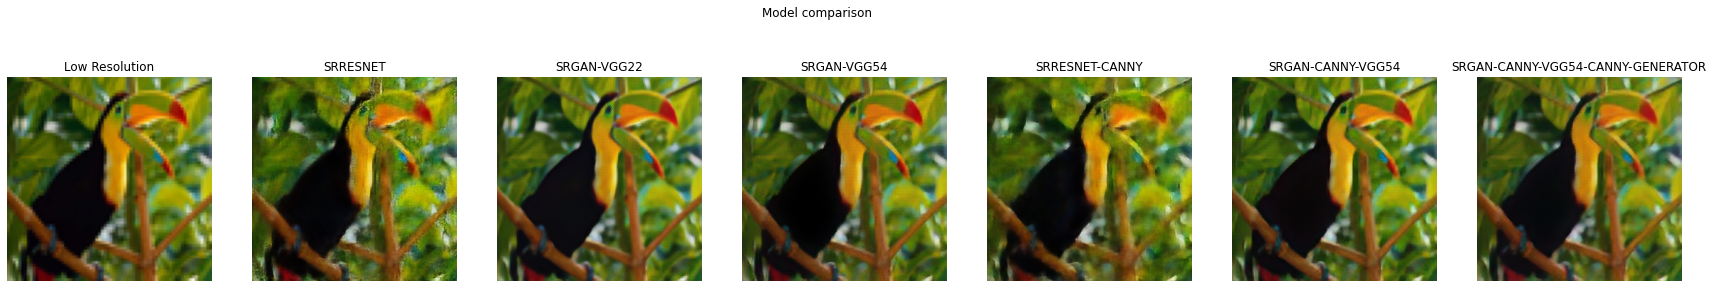

In [ ]:
#@title Comparison of our models results

# Take the n-th image of the set5 dataset
n = 2
iterator = iter(set5_dataset)
for i in range(n - 1):
  next(iterator)
lr, hr = next(iterator)

fig = plt.figure(figsize=(len(pretrained_models_drive_id) * 5, 5))

plt.subplot(1, len(pretrained_models_drive_id) + 1, 1)
plt.title("Low Resolution")
plt.axis("off")
plot_img_0_1(lr)

for i, model_name in enumerate(tqdm_notebook(pretrained_models_drive_id)):
  is_canny = "CANNY" in model_name
  gdrive_id = pretrained_models_drive_id[model_name]
  download_dataset(model_name + ".h5", gdrive_id, unzip=False)
  loaded_model = tf.keras.models.load_model(model_name + ".h5", custom_objects={"MySubpixelConv2D": MySubpixelConv2D})

  if is_canny:
    sr = loaded_model(np.array([lr]))[0][0]
  else:
    sr = loaded_model(np.array([lr]))[0]
  plt.subplot(1, len(pretrained_models_drive_id) + 1, i + 2)
  plot_img_1_1(sr)
  plt.title(model_name)
  plt.axis("off")


plt.suptitle("Model comparison")
plt.show();
